## Variant Calling Report v1.2.3
## Input Parameters

In [31]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nexusplt as nxp
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format
pd.set_option("max_colwidth", 100)

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id','pipeline_version',
          'h5_concordance_file', 'h5_model_file'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

h5outfile = parser.get('VarReport', 'h5_output', fallback='var_report.h5')
imgpref = parser.get('VarReport', 'image_output_prefix', fallback=prm['run_id']+'.vars')+'.'
imgdir = 'plots'

sources = {'Trained wo gt':(prm['h5_concordance_file'],"concordance"),
           'Trained with gt':(prm['h5_model_file'],"scored_concordance")
          }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    data[s]=d


prm['mean_var_depth']='{:.2f}'.format(data['Trained wo gt']['well_mapped_coverage'].mean())
prmNames.append('mean_var_depth')
   
try:
    args=pd.read_hdf(sources['Trained wo gt'][0], 'input_args', mode='r')
    prm['truth_sample_name']=args['truth_sample_name'][0]
except:
    prm['truth_sample_name']=parser.get('VarReport', 'truth_sample_name', fallback='NA')
prmNames.append('truth_sample_name')


prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,150450-BC21
pipeline_version,2.4.2
h5_concordance_file,/data/mutect2/data_simulation/filtervcf/150450...
h5_model_file,/data/mutect2/data_simulation/filtervcf/150450...
mean_var_depth,42.58
truth_sample_name,HG002


In [32]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                    (~data['LCR-hs38'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=10':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=10)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [54]:
def calcPerformance(data, gt=False):
    classify='classify_gt' if gt else 'classify'
    d=data.copy()
    
    d['tree_score'] = np.where(d[classify]=='fn',-1,d['tree_score'])
    d=d[[classify,'tree_score','filter']].sort_values(by=['tree_score'])
    
    d['label'] = np.where(d[classify]=='fp',0,1)

    d.loc[d['filter']=='HPOL_RUN','filter']='PASS'
    d.loc[d[classify]=='fn','filter']='MISS'
    d['class'] = np.where(d['label']==0,'FP','FN')
    d.loc[(d['label']==1) & (d['filter']=='PASS'),'class']='TP'
    d.loc[(d['label']==0) & (d['filter']!='PASS'),'class']='TN'

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    if len(d[d['mask']])==0:
        return (pd.DataFrame(),None,numPos,numNeg)

    # The model value
    fn=len(d[d['class']=='FN'])
    tp=len(d[d['class']=='TP'])
    fp=len(d[d['class']=='FP'])

    recall=tp/(tp+fn) if (tp+fn>0) else np.nan
    precision=tp/(tp+fp) if (tp+fp>0) else np.nan
    max_recall=1-len(d[d['filter']=='MISS'])/numPos

    f1=tp/(tp+0.5*fn+0.5*fp)
    
    return (d[['recall','precision']][d['mask']],
            dict({'recall':recall,'precision':precision,'f1':f1}),
            numPos,numNeg)



In [55]:
def plotPerformance(perfCurve,optRes,categories,ext=None,img=None):
    n=len(categories)
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(sources):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.get('recall'),opt.get('precision'),'o',color=col[j])
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    ax[0].legend(loc='lower left')
    
    if img:
        nxp.save(fig,imgpref+img,'png',outdir=imgdir)
    
    
def getPerformance(data,categories,gt=False):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d,gt)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'# pos':pos,
                              '# neg':neg,
                              'max recall':np.nan if perf.empty else max(perf.recall),
                              'recall':np.nan if perf.empty else opt.get('recall'),
                              'precision':np.nan if perf.empty else opt.get('precision'),
                              'F1':np.nan if perf.empty else opt.get('f1')
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve


## Performance: all Data

In [56]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary')

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

PASS         145861
MISS           3439
LOW_SCORE      1533
Name: filter, dtype: int64
TP    142642
FN      3530
FP      3219
TN      1442
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

PASS         9395
LOW_SCORE    1890
MISS         1637
Name: filter, dtype: int64
TP    7826
TN    1786
FN    1741
FP    1569
Name: class, dtype: int64
PASS         7168
LOW_SCORE    1621
MISS          687
Name: filter, dtype: int64
TP    5974
TN    1568
FP    1194
FN     740
Name: class, dtype: int64
PASS         2434
LOW_SCORE     902
MISS           75
Name: filter, dtype: int64
TP    2218
TN     871
FP     216
FN     106
Name: class, dtype: int64
PASS         1970
LOW_SCORE     417
MISS          109
Name: filter, dtype: int64
TP    1817
TN     356
FN     170
FP     153
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

        147262
MISS      3439
PASS       132
Name: filter, dtype: int64
FN    146040
TN      4661
TP       132
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

        11220
MISS     1637
PASS       65
Name: filter, dtype: int64
FN    9502
TN    3355
TP      65
Name: class, dtype: int64
        8776
MISS     687
PASS      13
Name: filter, dtype: int64
FN    6701
TN    2762
TP      13
Name: class, dtype: int64
        3327
MISS      75
PASS       9
Name: filter, dtype: int64
FN    2315
TN    1087
TP       9
Name: class, dtype: int64
        2382
MISS     109
PASS       5
Name: filter, dtype: int64
FN    1982
TN     509
TP       5
Name: class, dtype: int64


In [57]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers')

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

PASS         408
LOW_SCORE    201
MISS          15
Name: filter, dtype: int64
TP    364
TN    194
FP     44
FN     22
Name: class, dtype: int64
PASS         387
LOW_SCORE    134
MISS          15
Name: filter, dtype: int64
TP    335
TN    132
FP     52
FN     17
Name: class, dtype: int64
PASS         449
LOW_SCORE     93
MISS          19
Name: filter, dtype: int64
TP    424
TN     82
FN     30
FP     25
Name: class, dtype: int64
PASS         531
LOW_SCORE     73
MISS          28
Name: filter, dtype: int64
TP    506
TN     54
FN     47
FP     25
Name: class, dtype: int64
PASS         603
LOW_SCORE    117
MISS          47
Name: filter, dtype: int64
TP    552
TN     88
FN     76
FP     51
Name: class, dtype: int64
PASS         1232
MISS          350
LOW_SCORE     345
Name: filter, dtype: int64
TP    1116
FN     517
TN     178
FP     116
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

        609
MISS     15
Name: filter, dtype: int64
FN    386
TN    238
Name: class, dtype: int64
        519
MISS     15
PASS      2
Name: filter, dtype: int64
FN    350
TN    184
TP      2
Name: class, dtype: int64
        540
MISS     19
PASS      2
Name: filter, dtype: int64
FN    452
TN    107
TP      2
Name: class, dtype: int64
        603
MISS     28
PASS      1
Name: filter, dtype: int64
FN    552
TN     79
TP      1
Name: class, dtype: int64
        720
MISS     47
Name: filter, dtype: int64
FN    628
TN    139
Name: class, dtype: int64
        1574
MISS     350
PASS       3
Name: filter, dtype: int64
FN    1630
TN     294
TP       3
Name: class, dtype: int64


In [58]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data")
df

Trained w.o gt                                    \
                                # pos # neg max recall recall precision   
SNP                            146172  4661     97.65% 97.59%    97.79%   
non-hmer Indel                   9567  3355     82.89% 81.80%    83.30%   
non-hmer Indel w/o LCR           6714  2762     89.77% 88.98%    83.34%   
hmer Indel <=4                   2324  1087     96.77% 95.44%    91.13%   
hmer Indel >4,<=8                1987   509     94.51% 91.44%    92.23%   
hmer Indel 4                      386   238     96.11% 94.30%    89.22%   
hmer Indel 5                      352   184     95.74% 95.17%    86.56%   
hmer Indel 6                      454   107     95.81% 93.39%    94.43%   
hmer Indel 7                      553    79     94.94% 91.50%    95.29%   
hmer Indel 8                      628   139     92.52% 87.90%    91.54%   
hmer Indel >8,<=10               1633   294     78.51% 68.34%    90.58%   

                              Trained with gt                          \
                           F1           # pos # neg max recall recall   
SNP                    97.69%          146172  4661     97.65%  0.09%   
non-hmer Indel         82.54%            9567  3355     82.89%  0.68%   
non-hmer Indel w/o LCR 86.07%            6714  2762     89.77%  0.19%   
hmer Indel <=4         93.23%            2324  1087     96.77%  0.39%   
hmer Indel >4,<=8      91.84%            1987   509     94.51%  0.25%   
hmer Indel 4           91.69%             386   238     96.11%  0.00%   
hmer Indel 5           90.66%             352   184     95.74%  0.57%   
hmer Indel 6           93.91%             454   107     95.81%  0.44%   
hmer Indel 7           93.36%             553    79     94.94%  0.18%   
hmer Indel 8           89.68%             628   139     92.36%  0.00%   
hmer Indel >8,<=10     77.91%            1633   294     78.57%  0.18%   

                                        
                       precision    F1  
SNP                      100.00% 0.18%  
non-hmer Indel           100.00% 1.35%  
non-hmer Indel w/o LCR   100.00% 0.39%  
hmer Indel <=4           100.00% 0.77%  
hmer Indel >4,<=8        100.00% 0.50%  
hmer Indel 4                nan% 0.00%  
hmer Indel 5             100.00% 1.13%  
hmer Indel 6             100.00% 0.88%  
hmer Indel 7             100.00% 0.36%  
hmer Indel 8                nan% 0.00%  
hmer Indel >8,<=10       100.00% 0.37%

### Including genotype

In [59]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(data,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

PASS         145370
MISS           3934
LOW_SCORE      1529
Name: filter, dtype: int64
TP    142063
FN      4018
FP      3307
TN      1445
Name: class, dtype: int64
PASS         9152
MISS         1898
LOW_SCORE    1872
Name: filter, dtype: int64
TP    7415
FN    1978
TN    1792
FP    1737
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

PASS         7068
LOW_SCORE    1614
MISS          794
Name: filter, dtype: int64
TP    5816
TN    1571
FP    1252
FN     837
Name: class, dtype: int64
PASS         2417
LOW_SCORE     902
MISS           92
Name: filter, dtype: int64
TP    2202
TN     872
FP     215
FN     122
Name: class, dtype: int64
PASS         1947
LOW_SCORE     413
MISS          136
Name: filter, dtype: int64
TP    1783
TN     356
FN     193
FP     164
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

        146899
MISS      3934
Name: filter, dtype: int64
FN    146081
TN      4752
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

        11024
MISS     1898
Name: filter, dtype: int64
FN    9393
TN    3529
Name: class, dtype: int64
        8682
MISS     794
Name: filter, dtype: int64
FN    6653
TN    2823
Name: class, dtype: int64
        3319
MISS      92
Name: filter, dtype: int64
FN    2324
TN    1087
Name: class, dtype: int64
        2360
MISS     136
Name: filter, dtype: int64
FN    1976
TN     520
Name: class, dtype: int64


In [60]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_gt")
df

Trained w.o gt                                    \
                                # pos # neg max recall recall precision   
SNP                            146081  4752     97.31% 97.25%    97.73%   
non-hmer Indel                   9393  3529     79.79% 78.94%    81.02%   
non-hmer Indel w/o LCR           6653  2823     88.07% 87.42%    82.29%   
hmer Indel <=4                   2324  1087     96.04% 94.75%    91.10%   
hmer Indel >4,<=8                1976   520     93.12% 90.23%    91.58%   

                              Trained with gt                          \
                           F1           # pos # neg max recall recall   
SNP                    97.49%          146081  4752     97.31%  0.00%   
non-hmer Indel         79.97%            9393  3529     79.79%  0.00%   
non-hmer Indel w/o LCR 84.78%            6653  2823     88.07%  0.00%   
hmer Indel <=4         92.89%            2324  1087     96.04%  0.00%   
hmer Indel >4,<=8      90.90%            1976   520     93.12%  0.00%   

                                        
                       precision    F1  
SNP                         nan% 0.00%  
non-hmer Indel              nan% 0.00%  
non-hmer Indel w/o LCR      nan% 0.00%  
hmer Indel <=4              nan% 0.00%  
hmer Indel >4,<=8           nan% 0.00%

### homozygous genotyping accuracy

In [61]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=data[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_homozygous")
df

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

PASS         52653
MISS           414
LOW_SCORE       11
Name: filter, dtype: int64
TP    52653
FN      425
Name: class, dtype: int64
PASS         2652
MISS          149
LOW_SCORE      14
Name: filter, dtype: int64
TP    2636
FN     160
FP      16
TN       3
Name: class, dtype: int64
PASS         2128
MISS           73
LOW_SCORE       8
Name: filter, dtype: int64
TP    2120
FN      79
FP       8
TN       2
Name: class, dtype: int64
PASS    809
MISS     10
Name: filter, dtype: int64
TP    807
FN     10
FP      2
Name: class, dtype: int64
PASS         669
MISS          20
LOW_SCORE      1
Name: filter, dtype: int64
TP    669
FN     21
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

        52664
MISS      414
Name: filter, dtype: int64
FN    53078
Name: class, dtype: int64
        2666
MISS     149
Name: filter, dtype: int64
FN    2796
TN      19
Name: class, dtype: int64
        2136
MISS      73
Name: filter, dtype: int64
FN    2199
TN      10
Name: class, dtype: int64
        809
MISS     10
Name: filter, dtype: int64
FN    817
TN      2
Name: class, dtype: int64
        670
MISS     20
Name: filter, dtype: int64
FN    690
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trained w.o gt                                    \
                                # pos # neg max recall recall precision   
SNP                             53078     0     99.22% 99.20%   100.00%   
non-hmer Indel                   2796    19     94.64% 94.28%    99.40%   
non-hmer Indel w/o LCR           2199    10     96.63% 96.41%    99.62%   
hmer Indel <=4                    817     2     98.65% 98.78%    99.75%   
hmer Indel >4,<=8                 690     0     96.96% 96.96%   100.00%   

                              Trained with gt                          \
                           F1           # pos # neg max recall recall   
SNP                    99.60%           53078     0     99.22%  0.00%   
non-hmer Indel         96.77%            2796    19     94.64%  0.00%   
non-hmer Indel w/o LCR 97.99%            2199    10     96.63%  0.00%   
hmer Indel <=4         99.26%             817     2     98.65%  0.00%   
hmer Indel >4,<=8      98.45%             690     0     96.96%  0.00%   

                                        
                       precision    F1  
SNP                         nan% 0.00%  
non-hmer Indel              nan% 0.00%  
non-hmer Indel w/o LCR      nan% 0.00%  
hmer Indel <=4              nan% 0.00%  
hmer Indel >4,<=8           nan% 0.00%

## Performance: cvg>=20, mappability.0

In [1]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary')


NameError: name 'sources' is not defined

In [63]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers')


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

PASS         392
LOW_SCORE    177
MISS           3
Name: filter, dtype: int64
TP    353
TN    172
FP     39
FN      8
Name: class, dtype: int64
PASS         370
LOW_SCORE    122
MISS           5
Name: filter, dtype: int64
TP    322
TN    120
FP     48
FN      7
Name: class, dtype: int64
PASS         428
LOW_SCORE     81
MISS           6
Name: filter, dtype: int64
TP    409
TN     74
FP     19
FN     13
Name: class, dtype: int64
PASS         520
LOW_SCORE     70
MISS          21
Name: filter, dtype: int64
TP    499
TN     53
FN     38
FP     21
Name: class, dtype: int64
PASS         594
LOW_SCORE    113
MISS          34
Name: filter, dtype: int64
TP    544
TN     85
FN     62
FP     50
Name: class, dtype: int64
PASS         1214
LOW_SCORE     337
MISS          323
Name: filter, dtype: int64
TP    1106
FN     487
TN     173
FP     108
Name: class, dtype: int64


/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

        569
MISS      3
Name: filter, dtype: int64
FN    361
TN    211
Name: class, dtype: int64
        490
MISS      5
PASS      2
Name: filter, dtype: int64
FN    327
TN    168
TP      2
Name: class, dtype: int64
        508
MISS      6
PASS      1
Name: filter, dtype: int64
FN    421
TN     93
TP      1
Name: class, dtype: int64
        589
MISS     21
PASS      1
Name: filter, dtype: int64
FN    536
TN     74
TP      1
Name: class, dtype: int64
        707
MISS     34
Name: filter, dtype: int64
FN    606
TN    135
Name: class, dtype: int64
        1548
MISS     323
PASS       3
Name: filter, dtype: int64
FN    1590
TN     281
TP       3
Name: class, dtype: int64


In [64]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data")
defTable=df.copy()
df

Trained w.o gt                                    \
                                # pos # neg max recall recall precision   
SNP                            138074  3660     99.69% 99.67%    98.27%   
non-hmer Indel                   8101  3110     91.59% 90.57%    83.38%   
non-hmer Indel w/o LCR           6044  2564     94.85% 94.19%    83.56%   
hmer Indel <=4                   2201   937     99.18% 97.96%    91.74%   
hmer Indel >4,<=8                1894   470     96.52% 93.66%    92.78%   
hmer Indel 4                      361   211     99.17% 97.78%    90.05%   
hmer Indel 5                      329   168     98.48% 97.87%    87.03%   
hmer Indel 6                      422    93     98.58% 96.92%    95.56%   
hmer Indel 7                      537    74     96.09% 92.92%    95.96%   
hmer Indel 8                      606   135     94.39% 89.77%    91.58%   
hmer Indel >8,<=10               1593   281     79.66% 69.43%    91.10%   

                              Trained with gt                          \
                           F1           # pos # neg max recall recall   
SNP                    98.97%          138074  3660     99.69%  0.09%   
non-hmer Indel         86.82%            8101  3110     91.59%  0.70%   
non-hmer Indel w/o LCR 88.56%            6044  2564     94.85%  0.20%   
hmer Indel <=4         94.75%            2201   937     99.18%  0.41%   
hmer Indel >4,<=8      93.22%            1894   470     96.52%  0.21%   
hmer Indel 4           93.76%             361   211     99.17%  0.00%   
hmer Indel 5           92.13%             329   168     98.48%  0.61%   
hmer Indel 6           96.24%             422    93     98.58%  0.24%   
hmer Indel 7           94.42%             537    74     96.09%  0.19%   
hmer Indel 8           90.67%             606   135     94.22%  0.00%   
hmer Indel >8,<=10     78.80%            1593   281     79.72%  0.19%   

                                        
                       precision    F1  
SNP                      100.00% 0.18%  
non-hmer Indel           100.00% 1.40%  
non-hmer Indel w/o LCR   100.00% 0.40%  
hmer Indel <=4           100.00% 0.81%  
hmer Indel >4,<=8        100.00% 0.42%  
hmer Indel 4                nan% 0.00%  
hmer Indel 5             100.00% 1.21%  
hmer Indel 6             100.00% 0.47%  
hmer Indel 7             100.00% 0.37%  
hmer Indel 8                nan% 0.00%  
hmer Indel >8,<=10       100.00% 0.38%

### Including genotype

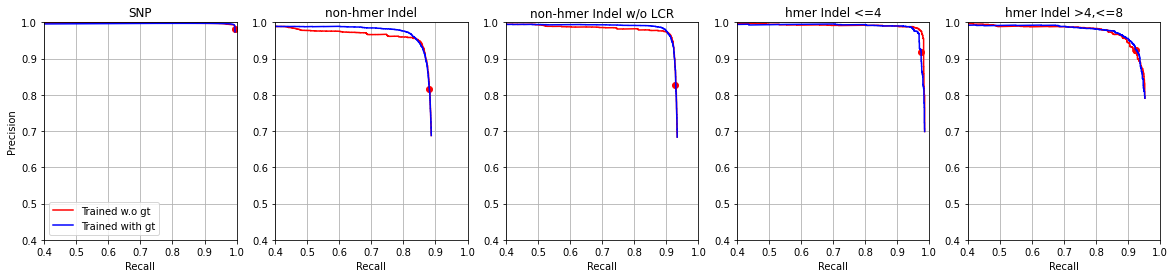

In [21]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

In [22]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_gt")
df

Trained w.o gt                                    \
                                # pos # neg max recall recall precision   
SNP                            138041  3693     99.50% 99.48%    98.24%   
non-hmer Indel                   7993  3218     88.70% 87.88%    81.74%   
non-hmer Indel w/o LCR           6008  2600     93.39% 92.81%    82.83%   
hmer Indel <=4                   2202   936     98.55% 97.32%    91.74%   
hmer Indel >4,<=8                1887   477     95.23% 92.58%    92.34%   

                              Trained with gt                          \
                           F1           # pos # neg max recall recall   
SNP                    98.86%          138041  3693     99.50%  0.00%   
non-hmer Indel         84.70%            7993  3218     88.70%  0.00%   
non-hmer Indel w/o LCR 87.54%            6008  2600     93.39%  0.00%   
hmer Indel <=4         94.45%            2202   936     98.55%  0.00%   
hmer Indel >4,<=8      92.46%            1887   477     95.23%  0.00%   

                                        
                       precision    F1  
SNP                         nan% 0.00%  
non-hmer Indel              nan% 0.00%  
non-hmer Indel w/o LCR      nan% 0.00%  
hmer Indel <=4              nan% 0.00%  
hmer Indel >4,<=8           nan% 0.00%

### homozygous calls

In [23]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df

Trained w.o gt                                    \
                                # pos # neg max recall recall precision   
SNP                             50774     0     99.63% 99.63%   100.00%   
non-hmer Indel                   2584    13     95.24% 95.09%    99.47%   
non-hmer Indel w/o LCR           2064     7     97.29% 97.19%    99.65%   
hmer Indel <=4                    784     1     99.11% 99.11%    99.87%   
hmer Indel >4,<=8                 668     0     97.16% 97.16%   100.00%   

                              Trained with gt                          \
                           F1           # pos # neg max recall recall   
SNP                    99.81%           50774     0     99.63%  0.00%   
non-hmer Indel         97.23%            2584    13     95.24%  0.00%   
non-hmer Indel w/o LCR 98.41%            2064     7     97.29%  0.00%   
hmer Indel <=4         99.49%             784     1     98.98%  0.00%   
hmer Indel >4,<=8      98.56%             668     0     97.16%  0.00%   

                                        
                       precision    F1  
SNP                         nan% 0.00%  
non-hmer Indel              nan% 0.00%  
non-hmer Indel w/o LCR      nan% 0.00%  
hmer Indel <=4              nan% 0.00%  
hmer Indel >4,<=8           nan% 0.00%

### per base

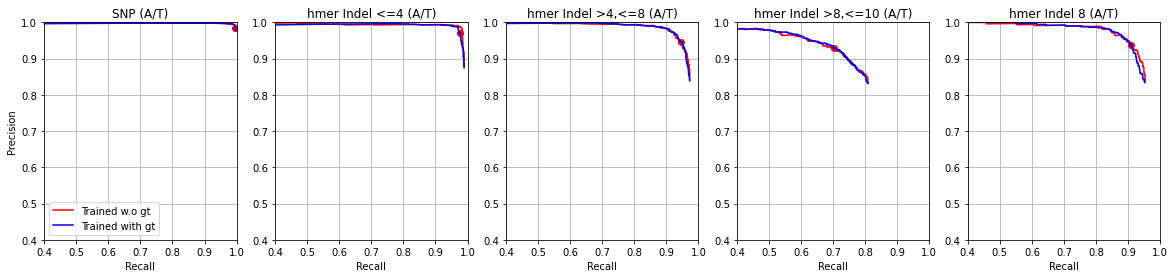

In [24]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'A/T')


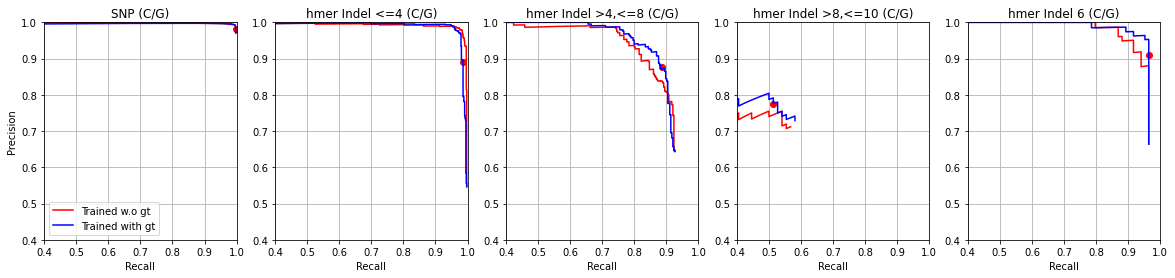

In [25]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'C/G')


In [26]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="per_base_data")
df

Trained w.o gt                                    \
                                  # pos # neg max recall recall precision   
SNP (A/T)                         65984  1479     99.65% 99.63%    98.39%   
hmer Indel <=4 (A/T)               1411   200     98.94% 97.66%    97.04%   
hmer Indel >4,<=8 (A/T)            1580   295     97.28% 94.68%    94.50%   
hmer Indel >8,<=10 (A/T)           1517   249     80.88% 70.40%    92.87%   
hmer Indel 8 (A/T)                  553   105     95.30% 90.96%    93.84%   
SNP (C/G)                         72090  2181     99.73% 99.71%    98.16%   
hmer Indel <=4 (C/G)                789   654     99.75% 98.61%    89.12%   
hmer Indel >4,<=8 (C/G)             314   162     92.68% 88.54%    87.70%   
hmer Indel >8,<=10 (C/G)             74    17     56.76% 51.35%    77.55%   
hmer Indel 6 (C/G)                   84    42     96.43% 96.43%    91.01%   

                                Trained with gt                          \
                             F1           # pos # neg max recall recall   
SNP (A/T)                99.00%           65984  1479     99.65%  0.09%   
hmer Indel <=4 (A/T)     97.35%            1411   200     98.94%  0.57%   
hmer Indel >4,<=8 (A/T)  94.59%            1580   295     97.28%  0.25%   
hmer Indel >8,<=10 (A/T) 80.09%            1517   249     80.82%  0.20%   
hmer Indel 8 (A/T)       92.38%             553   105     95.12%  0.00%   
SNP (C/G)                98.93%           72090  2181     99.73%  0.08%   
hmer Indel <=4 (C/G)     93.62%             789   654     99.75%  0.13%   
hmer Indel >4,<=8 (C/G)  88.11%             314   162     92.68%  0.00%   
hmer Indel >8,<=10 (C/G) 61.79%              74    17     58.11%  0.00%   
hmer Indel 6 (C/G)       93.64%              84    42     96.43%  0.00%   

                                          
                         precision    F1  
SNP (A/T)                  100.00% 0.18%  
hmer Indel <=4 (A/T)       100.00% 1.13%  
hmer Indel >4,<=8 (A/T)    100.00% 0.51%  
hmer Indel >8,<=10 (A/T)   100.00% 0.39%  
hmer Indel 8 (A/T)            nan% 0.00%  
SNP (C/G)                  100.00% 0.17%  
hmer Indel <=4 (C/G)       100.00% 0.25%  
hmer Indel >4,<=8 (C/G)       nan% 0.00%  
hmer Indel >8,<=10 (C/G)      nan% 0.00%  
hmer Indel 6 (C/G)            nan% 0.00%

In [27]:
%matplotlib agg
d=defTable['Trained with gt'][['max recall','recall','precision']]
labels=['SNP','nhmer','nhmer w/o LCR','hmer 2-4','hmer 5-8','hmer 4','hmer 5','hmer 6','hmer 7','hmer 8','hmer 9-10']
fig=plt.figure()
ax=d.plot()
plt.xticks(np.arange(len(d.index)), rotation=30, ha='right')
ax.set_xticklabels(labels)
plt.ylim([0.4,1.05])
plt.grid()
plt.title('Cvg>20X, Trained variant calls')
plt.tight_layout()
nxp.save(fig,imgpref+'summary','png',outdir=imgdir)
plt.close(fig)